This notebook evaluates performance of flat vs. hierarchical SVM models as a function of ontology depth using only the top 50 levels. The objectives are to: 

(1) See which levels might benefit from increased (SVM) regularization<br>
(2) Evaluate the the asymptotic performance of flat vs. hierarchical models as the ontology depth increases<br>
(3) Compare the above when using only the top 50 labels vs. all labels

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sys
import re
sys.path.append('../')
data_path = '../data/'
model_path = '../models/'
from icd9 import *
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 14,
                     'figure.titlesize': 14})

In [2]:
data = pd.read_csv(f'{data_path}restricted_mimic_iii/labeled_notes.csv')

In [3]:
# Use top 50 codes and splits
data = data.loc[data['50_split'] != 'other'].reset_index(drop=True)
data['fcode'] = data['fcode50']
data['split'] = data['50_split']

In [4]:
# Use basic text cleaning functions from reference book
# Citation: Python Machine Learning 2nd Edition, Raschka
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

def tokenize(text):
    return text.split()

In [5]:
# Preprocess all text
data['text'] = data['text'].apply(preprocessor)

In [6]:
# Instantiate ICD-9 tree but hold off on index for now
tree = ICD9Tree(f'{data_path}node_desc.csv', f'{data_path}node_parent.csv')

In [7]:
# Get distribution of depth of original labels
count_per_level = defaultdict(int)
unique_per_level = defaultdict(set)
all_codes = data['fcode'].copy()
all_codes.fillna('', inplace=True)
all_codes = all_codes.str.split(';').apply(set)

for all_code in all_codes:
    for code in all_code:
        if code != '':
            count_per_level[tree.get_node(code).depth] += 1
            unique_per_level[tree.get_node(code).depth].add(code)

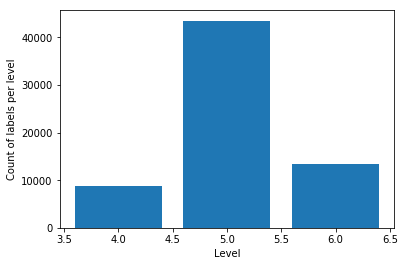

In [8]:
# Plot counts per level
levels = []
counts = []
for level, count in count_per_level.items():
    levels.append(level)
    counts.append(count)
    
plt.bar(levels, counts)
plt.xlabel('Level')
plt.ylabel('Count of labels per level')
plt.show()

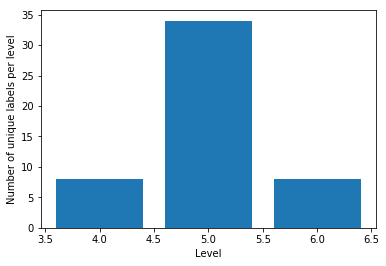

In [9]:
# Plot unique codes per level
levels = []
unique = []
for level, num_unique in unique_per_level.items():
    levels.append(level)
    unique.append(len(num_unique))
    
plt.bar(levels, unique)
plt.xlabel('Level')
plt.ylabel('Number of unique labels per level')
plt.show()

The second plot is of some use, but I really want to have this plot after mapping all labels up to each level. I will do that know to show what I mean. 

In [10]:
# This helper takes a series of sets of labels and maps to labels at
# a maximum depth in the ICD-9 ontology
def max_depth_labels(labels, max_depth, tree):
    """Helper for remapping labels to a maximum depth.
    
    labels : pandas Series of sets
        A series containing sets of labels.
    max_depth : int
        The maximum depth to map labels to.
    tree : ICD9Tree object
        A tree object used for mapping nodes to ancestors. 
    """
    # Builds a label-ancestor map for efficiency 
    temp_map = {}
    results = []
    for label_set in labels:
        temp_set = set()
        for label in label_set:
            if label in temp_map:
                temp_set.add(temp_map[label])
            else:
                if label != '':
                    temp_node = tree.get_node(label)
                    while temp_node.depth > max_depth:
                        temp_node = temp_node.parent
                    temp_map[label] = temp_node.code
                    temp_set.add(temp_node.code)
        results.append(temp_set)
        
    return pd.Series(results)

The minimum label depth is 4, maximum is 6. I will try running models with depths of 1 through 6. 

In [11]:
for i in range(1,7):
    data[f'depth_{i}'] = max_depth_labels(all_codes, i, tree).copy()

Now, I will revisit the number of unique labels at varying maximum depth levels. 

In [12]:
unique_per_max_depth = dict()
for i in range(1,7):
    temp_num_unique = set()
    for label_set in data[f'depth_{i}']:
        try:
            temp_num_unique = temp_num_unique.union(label_set)
        except:
            continue
    unique_per_max_depth[i] = len(temp_num_unique)

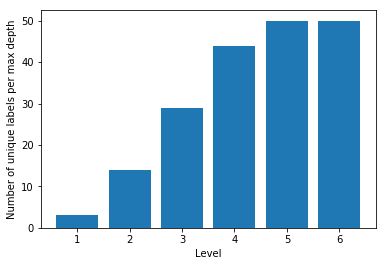

In [13]:
# Plot unique codes per level
levels = []
unique = []
for level, num_unique in unique_per_max_depth.items():
    levels.append(level)
    unique.append(num_unique)
    
plt.bar(levels, unique)
plt.xlabel('Level')
plt.xticks(levels)
plt.ylabel('Number of unique labels per max depth')
plt.show()

The growth factor is less extreme than in the case with all of the labels. 

Finally, I would like to see how the distribution of samples per unique code varies as a function of maximum depth.

In [14]:
def samples_per_label(labels):
    """Counts samples per label in labels"""
    temp_counts = defaultdict(int)
    for label_set in labels:
        for label in label_set:
            temp_counts[label] += 1
    return temp_counts.values()

num_samples_per_label = []
for i in range(1,7):
    num_samples_per_label.append(samples_per_label(data[f'depth_{i}']))

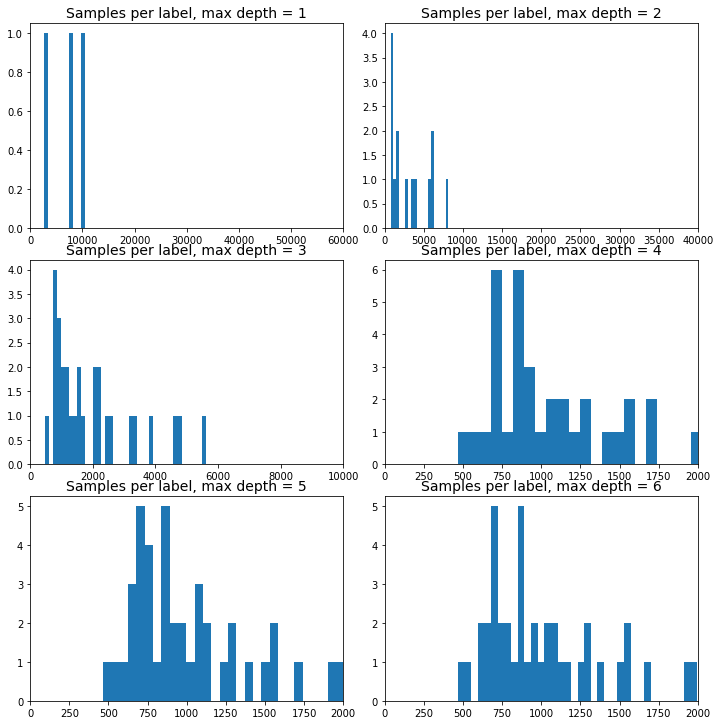

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(10,10))
fig.tight_layout()
bins = [10, 20, 40, 60, 80, 100, 200]
x_lim = [60000, 40000, 10000, 2000, 2000, 2000, 2000]
for i, ax in zip(range(6), axs.flat):
    ax.hist(num_samples_per_label[i], bins=bins[i])
    ax.set_title(f"Samples per label, max depth = {i+1}")
    ax.set_xlim(0,x_lim[i])
plt.show()

Now, I will continue by evaluating flat vs. hierarchical model performance with varying maximum depth levels.

For now, I will follow Perotte 2014 and use only the top 10,000 most frequent unigrams. 

In [16]:
# Next, fit tfidf to training data and transform other splits
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                   tokenizer=tokenize,
                                   ngram_range=(1,1),
                                   max_features=10000)

train_data = data.loc[data['split']=='train',:].reset_index()
val_data = data.loc[data['split']=='val',:].reset_index()
test_data = data.loc[data['split']=='test',:].reset_index()

train_X = tfidf_vectorizer.fit_transform(train_data['text'].values)
val_X = tfidf_vectorizer.transform(val_data['text'].values)
test_X = tfidf_vectorizer.transform(test_data['text'].values)

### Fitting and evaluating hierarchical models at varying depths

The code below fits (or loads if pretrained) hierarchical models at varying depths and computes the evaluation metrics for each one.

In [17]:
# Function for comparing flat and hierarchical models
def flat_v_hier_eval(df, h_preds, f_preds, codes='fcode', title='',
                     verbose=True):
    """Helper for evaluating flat v. hierarchical models.
    
    df : pandas DataFrame
        The evaluation set features and true labels.
    h_preds : list of lists of code Strings
        Labels predicted by the hierarchical model.
    f_preds : list of lists of code Strings
        Labels predicted by the flat model.
    codes : String
        The name of the column containing the codes as ";" delimited
        String.
    title : String
        A title for the comparison.
    """
    df['h_preds'] = pd.Series(h_preds).apply(set)
    df['f_preds'] = pd.Series(f_preds).apply(set)

    df['h_match'] = 0
    df['f_match'] = 0

#     df[codes].fillna('', inplace=True)
#     df[codes] = df[codes].str.split(';').apply(set)
    df['fcode'] = df[codes]

    for idx, row in df.iterrows():
        df.loc[idx, 'h_match'] = len(row.fcode.intersection(row.h_preds))

    for idx, row in df.iterrows():
        df.loc[idx, 'f_match'] = len(row.fcode.intersection(row.f_preds)) 
        
    def f1_score(prec, recall):
        """Compute f1 score
        
        Source: https://en.wikipedia.org/wiki/F1_score
        """
        return 2 * (prec * recall)/(prec + recall)

    h_prec = df['h_match'].sum() / df['h_preds'].apply(len).sum()
    h_recall = df['h_match'].sum() / df['fcode'].apply(len).sum()

    f_prec = df['f_match'].sum() / df['f_preds'].apply(len).sum()
    f_recall = df['f_match'].sum() / df['fcode'].apply(len).sum()

    if verbose:
        print(title)
        print(f'Flat micro-avg metrics: precision = {f_prec:.2f}, recall = {f_recall:.2f}, f1 = {f1_score(f_prec, f_recall):.2f}')
        print(f'Hierarchical micro-avg metrics: precision = {h_prec:.2f}, recall = {h_recall:.2f}, f1 = {f1_score(h_prec, h_recall):.2f}')
    
    return h_prec, h_recall, f_prec, f_recall

In [18]:
def fit_eval_at_depth(train_X, val_X, train_data, val_data, max_depth,
                      model_path, data_path, pretrained=False,
                      verbose=True):
    """Fits an SVM ensemble and prints evaluation metrics
    
    train_X : tfidf matrix
        Preprocessed training set tfidf features
    val_X : tfidf matrix
        Preprocessed validation set tfidf features
    train_data : pandas DataFrame
        pandas DataFrame containing all of the max depth labels.
    val_data : pandas DataFrame
        pandas DataFrame containing all of the max depth labels
    max_depth : int
        Maximum code depth to fit and evaluate at.
    model_path : String
        Base path for either saving or loading models.
    data_path : String
        File path with the tree construction data.
    pretrained : bool
        Whether to save or load models. 
    """
    tree = ICD9Tree(f'{data_path}node_desc.csv', f'{data_path}node_parent.csv')
    tree.index_df(train_data, codes=f'depth_{max_depth}', code_format='set')
    test_node = tree.root
    if pretrained:
        tree.load_models(model_path+'50_md'+str(max_depth)+'_hsvm_C1.obj',
                         model_type = 'h')
        tree.load_models(model_path+'50_md'+str(max_depth)+'_fsvm_C1.obj',
                         model_type = 'f')
    else:
        tree.fit_hmodel(train_X, test_node, max_depth=None)
        tree.save_models(model_path+'50_md'+str(max_depth)+'_hsvm_C1.obj',
                         model_type='h')
        tree.fit_fmodel(train_X, test_node, max_depth=None)
        tree.save_models(model_path+'50_md'+str(max_depth)+'_fsvm_C1.obj',
                         model_type='f')
        
    h_preds_train = tree.predict_hmodel(train_X, test_node)
    h_preds_val = tree.predict_hmodel(val_X, test_node)
    
    f_preds_train = tree.predict_fmodel(train_X, test_node)
    f_preds_val = tree.predict_fmodel(val_X, test_node)
    
    # Training set eval
    train_metrics = flat_v_hier_eval(train_data, h_preds_train, f_preds_train,
                                     codes=f'depth_{max_depth}',
                                     title=f'Training; Max. Depth {max_depth}',
                                     verbose=verbose)
    
    # Validation set eval
    val_metrics = flat_v_hier_eval(val_data, h_preds_val, f_preds_val,
                                   codes=f'depth_{max_depth}',
                                   title=f'Validation; Max. Depth {max_depth}',
                                   verbose=verbose)
    
    return [max_depth] + list(train_metrics) + list(val_metrics)

In [19]:
# Evaluate models at max depth of 1 through 6
results = []
for i in range(1,7):
    results.append(fit_eval_at_depth(train_X, val_X, train_data,
                                     val_data, i, model_path,
                                     data_path, pretrained=True))

Training; Max. Depth 1
Flat micro-avg metrics: precision = 0.97, recall = 0.96, f1 = 0.97
Hierarchical micro-avg metrics: precision = 0.97, recall = 0.96, f1 = 0.97
Validation; Max. Depth 1
Flat micro-avg metrics: precision = 0.89, recall = 0.86, f1 = 0.88
Hierarchical micro-avg metrics: precision = 0.89, recall = 0.87, f1 = 0.88
Training; Max. Depth 2
Flat micro-avg metrics: precision = 0.95, recall = 0.87, f1 = 0.91
Hierarchical micro-avg metrics: precision = 0.94, recall = 0.90, f1 = 0.92
Validation; Max. Depth 2
Flat micro-avg metrics: precision = 0.77, recall = 0.59, f1 = 0.67
Hierarchical micro-avg metrics: precision = 0.74, recall = 0.63, f1 = 0.68
Training; Max. Depth 3
Flat micro-avg metrics: precision = 0.96, recall = 0.82, f1 = 0.88
Hierarchical micro-avg metrics: precision = 0.92, recall = 0.89, f1 = 0.90
Validation; Max. Depth 3
Flat micro-avg metrics: precision = 0.75, recall = 0.49, f1 = 0.60
Hierarchical micro-avg metrics: precision = 0.66, recall = 0.57, f1 = 0.61
Trai

In [20]:
# Convert to DataFrame and Generate Summary Plots
results_df = pd.DataFrame(results, columns=['max_depth', 'h_prec_train', 'h_rec_train',
                                            'f_prec_train', 'f_rec_train',
                                            'h_prec_val', 'h_rec_val',
                                            'f_prec_val', 'f_rec_val'])
results_df['h_f1_train'] = 0
results_df['f_f1_train'] = 0
results_df['h_f1_val'] = 0
results_df['f_f1_val'] = 0

def f1_score(prec, recall):
    """Compute f1 score

    Source: https://en.wikipedia.org/wiki/F1_score
    """
    return 2 * (prec * recall)/(prec + recall)

for idx, row in results_df.iterrows():
    results_df.loc[idx, 'h_f1_train'] = f1_score(row.h_prec_train, row.h_rec_train)
    results_df.loc[idx, 'f_f1_train'] = f1_score(row.f_prec_train, row.f_rec_train)
    results_df.loc[idx, 'h_f1_val'] = f1_score(row.h_prec_val, row.h_rec_val)
    results_df.loc[idx, 'f_f1_val'] = f1_score(row.f_prec_val, row.f_rec_val)

In [21]:
results_df.head()

,max_depth,h_prec_train,h_rec_train,f_prec_train,f_rec_train,h_prec_val,h_rec_val,f_prec_val,f_rec_val,h_f1_train,f_f1_train,h_f1_val,f_f1_val
0,1,0.972770,0.963848,0.973487,0.963580,0.891350,0.865779,0.892063,0.863730,0.968289,0.968508,0.878378,0.877668
1,2,0.936684,0.895491,0.953725,0.873222,0.735332,0.625272,0.770043,0.589680,0.915624,0.911700,0.675850,0.667899
2,3,0.915337,0.886257,0.957864,0.816415,0.660906,0.566618,0.754386,0.494979,0.900563,0.881501,0.610140,0.597752
3,4,0.904773,0.883080,0.963509,0.775440,0.589089,0.516738,0.745888,0.408188,0.893795,0.859305,0.550547,0.527630
4,5,0.899579,0.879875,0.966210,0.747752,0.547922,0.485012,0.727055,0.361757,0.889618,0.843059,0.514551,0.483127


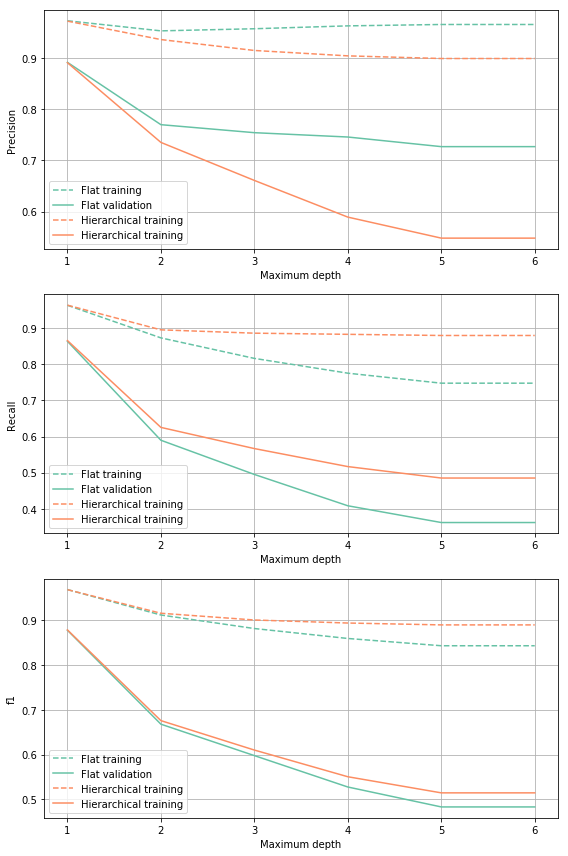

In [22]:
def subplot_helper(ax, metric, x, f_train, f_val, h_train, h_val):
    # Credit: http://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3
    colors = ['#66c2a5','#fc8d62','#8da0cb']
    ax.plot(x, f_train, color=colors[0], linestyle='--', label='Flat training')
    ax.plot(x, f_val, color=colors[0], label='Flat validation')
    ax.plot(x, h_train, color=colors[1], linestyle='--', label='Hierarchical training')
    ax.plot(x, h_val, color=colors[1], label='Hierarchical training')
    ax.set_xlabel('Maximum depth')
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid()

fig, axs = plt.subplots(3,1, figsize=(8,12))
subplot_helper(axs[0], 'Precision', results_df.max_depth, results_df.f_prec_train, results_df.f_prec_val,
               results_df.h_prec_train, results_df.h_prec_val)
subplot_helper(axs[1], 'Recall', results_df.max_depth, results_df.f_rec_train, results_df.f_rec_val,
               results_df.h_rec_train, results_df.h_rec_val)
subplot_helper(axs[2], 'f1', results_df.max_depth, results_df.f_f1_train, results_df.f_f1_val,
               results_df.h_f1_train, results_df.h_f1_val)
fig.tight_layout()
plt.show()